In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from sympy import Symbol, exp, pi, Poly, fraction, Add, Mul, latex, Pow  # noqa
from functools import reduce
from IPython.display import Math, display
import sympy as sy

import re


def replace_latex_powers(latex_str):
    return re.sub(r"\\left\(z\^\{-1\}\\right\)\^\{(\d+)\}", r"z^{-\1}", latex_str)


def evalf_poly(expr, var):
    return reduce(
        lambda x, y: Add(x, y, evaluate=True),
        [
            c.evalf() * var**ix
            for ix, c in enumerate(reversed(expr.as_poly(var).all_coeffs()))
        ],
    )


def poly_coeffs(expr, var):
    return expr.as_poly(var).all_coeffs()


f_k = Symbol("f_k")
f_s = Symbol("f_s")
tau_k = Symbol("tau_k")
A_k = Symbol("A_k")
z_inv = Symbol("z^-1")


p_k = exp(2j * pi * f_k / f_s) * exp(-1 / (tau_k * f_s))
a_2_k = abs(p_k) ** 2
a_1_k = -2 * sy.re(p_k)
b_k = A_k / f_s * sy.im(p_k)

H_res_k_numerator = b_k * z_inv
H_res_k_denominator = 1 + a_1_k * z_inv + a_2_k * z_inv**2
vals = {f_k: 440 * 4, f_s: 44100, tau_k: 0.2, A_k: 10.0}


H_res_k_numerator = evalf_poly(H_res_k_numerator.subs(vals), z_inv)
H_res_k_denominator = evalf_poly(H_res_k_denominator.subs(vals), z_inv)

print("transfer function:")
display(
    Math(
        r"H_{\text{res}, k} = "
        + replace_latex_powers(
            latex(
                Mul(
                    (H_res_k_numerator),
                    Pow((H_res_k_denominator), -1, evaluate=True),
                    evaluate=False,
                )
            )
        )
    )
)

transfer function:


<IPython.core.display.Math object>

In [36]:
import numpy as np

b = np.array(poly_coeffs(H_res_k_numerator, z_inv)[::-1]).astype(np.float64)
a = np.array(poly_coeffs(H_res_k_denominator, z_inv)[::-1]).astype(np.float64)

/Users/briancruz/repos/research/music_299_2025sp/.venv/lib/python3.12/site-packages/setuptools/config/expand.py:128: SetuptoolsWarning: File '/Users/briancruz/repos/research/music_299_2025sp/requirements-test.txt' cannot be found
  for path in _filter_existing_files(_filepaths)
.venv/lib/python3.12/site-packages/FAUSTPy/__pycache__/_cffi__xe97ccfcdx9af39989.c:495:3: warning: code will never be executed [-Wunreachable-code]
  495 |   _cffi_check__MetaGlue(0);
      |   ^~~~~~~~~~~~~~~~~~~~~
.venv/lib/python3.12/site-packages/FAUSTPy/__pycache__/_cffi__xe97ccfcdx9af39989.c:564:3: warning: code will never be executed [-Wunreachable-code]
  564 |   _cffi_check__UIGlue(0);
      |   ^~~~~~~~~~~~~~~~~~~
.venv/lib/python3.12/site-packages/FAUSTPy/__pycache__/_cffi__xe97ccfcdx9af39989.c:585:3: warning: code will never be executed [-Wunreachable-code]
  585 |   _cffi_check__mydsp(0);
      |   ^~~~~~~~~~~~~~~~~~
3 warnings generated.
ld: warning: duplicate -rpath '/Users/briancruz/.micromamba/e

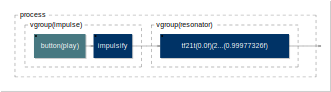

(1, 50000)


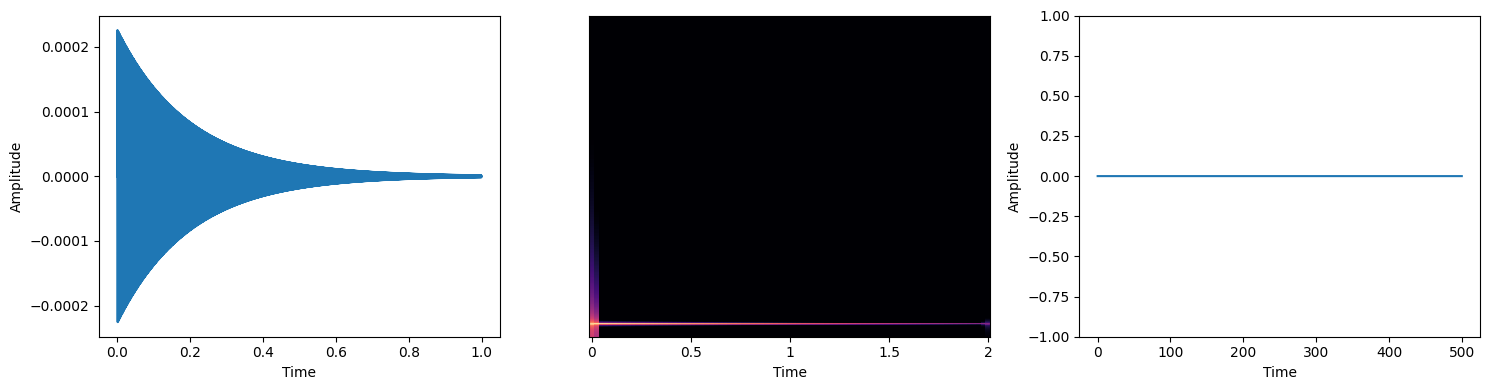

In [37]:
from pyfaust import FaustProcessor

code = f"""
import("stdfaust.lib");

b0 = {b[0]};
b1 = {b[1]};
b2 = 0.0;
a1 = {a[1]};
a2 = {a[2]};

process = vgroup("impulse", (button("play"): ba.impulsify))
		: vgroup("resonator", fi.tf21t(b0,b1,b2,a1,a2));
"""
with FaustProcessor(code) as fp:
    fp.show_signal_graph()

    fp.dsp.dsp.b_impulse.p_play.zone = 1

    N_samples = 50000
    out = fp.compute(N_samples)
    out.play(normalize=True)


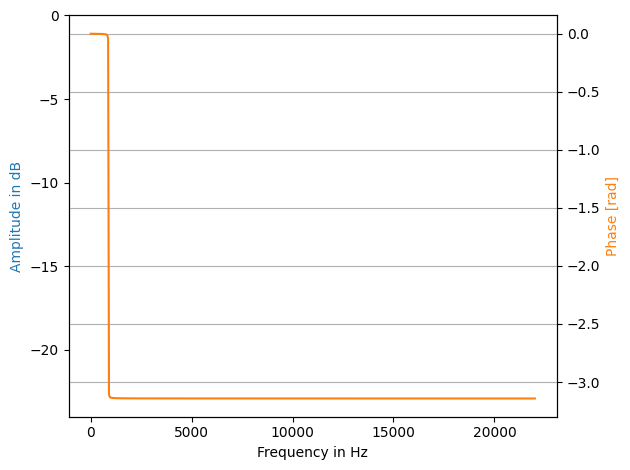

In [46]:
from audio_utils import plot_freqz

plot_freqz(b, a)

In [43]:
a

array([ 1.        , -1.98407579,  0.99977327])

In [45]:
from scipy.signal import freqz

w, h = freqz(b, a, worN=8000)
abs(h)

array([1.80620759e-03, 1.80622533e-03, 1.80627856e-03, ...,
       7.11696716e-06, 7.11696579e-06, 7.11696496e-06])